<a href="https://colab.research.google.com/github/JJEEEFFFF/CE889-Labs/blob/main/Assignment/EEG_Assignment_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import scipy.fft as fft
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

**Loading The Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data = io.loadmat('/content/drive/MyDrive/Neural Networks/WLDataCW.mat')
print('Length: ' + str(len(data)))
print(data.keys())
print(data['__globals__'])
data_only = data["data"]
label = data["label"]
print(data_only.shape)
print(label.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Length: 5
dict_keys(['__header__', '__version__', '__globals__', 'data', 'label'])
[]
(62, 512, 360)
(1, 360)


# **Preprocessing**

In [3]:
D = np.array(data_only)
GT = np.array(label)

newData = D.reshape((D.shape[0] * D.shape[1]), D.shape[2])

train_index = int(0.8 * newData.shape[1])
X_train, X_test = newData[:, :train_index ], newData[:, train_index :]
y_train, y_test = GT[:, :train_index ], GT[:, train_index :]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
w = np.full((X_train.shape[0], 1), 0.255)
b = np.full((1, y_train.shape[1]), 0.5)

print(w, w.shape)
print(b, b.shape)

y = preprocessing.maxabs_scale(X_train)
GT = preprocessing.maxabs_scale(y_train)
print(GT)

x = np.real(fft.fft2(y))

(31744, 288) (1, 288) (31744, 72) (1, 72)
[[0.255]
 [0.255]
 [0.255]
 ...
 [0.255]
 [0.255]
 [0.255]] (31744, 1)
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5

# **FORMULAS**

In [4]:

def forwardPropagationSigmoid(xvalue):
    sig = (1/(1+np.exp(-xvalue)))
    return sig

def assessment(y1, y2):
    m = y1.shape[1]
    lossWB = (-1/m)*np.sum(np.multiply(y1, np.log(y2+0.1)) + np.multiply((1-y1), np.log(1-y2+0.1)))
    return lossWB

def gradientWeight(x, y1, y2):
    gradientW = np.dot(x, (y2 - y1).transpose()) / (y1.shape[0]*y1.shape[1])
    return gradientW

def gradientBias(x, y1, y2):
    gradient = ((y2 - y1).sum() / (y1.shape[0]*y1.shape[1]))
    return gradient

def updatingWeights(x, y1, y2):
    learningRate = 0.61
    updatedW = w - learningRate * gradientWeight(x, y1, y2)
    updatedB = b - learningRate * gradientBias(x, y1, y2)
    return updatedW, updatedB

In [5]:
lossAll = []
dAll = [w]


for i in range(0, 1000):
    calc = np.dot(w.transpose(), y) + b
    yCalc = forwardPropagationSigmoid(calc)
    print(yCalc.shape, yCalc.dtype)
    print(yCalc)
    print(yCalc.shape)
    loss = assessment(y_train, yCalc)
    lossAll.append(loss)
    if loss <= 0.0001:
        break
    w, b = updatingWeights(y, y_train, yCalc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
  1.00000000e+000 1.93913709e-051 1.00000000e+000 1.00000000e+000
  1.00000000e+000 2.77261120e-049 6.14649596e-012 1.00000000e+000
  9.92951033e-001 6.32864361e-039 2.00548044e-025 1.00000000e+000
  2.90260822e-042 1.00000000e+000 3.31549244e-029 1.00000000e+000
  2.65242129e-004 1.00000000e+000 1.00000000e+000 1.41578124e-093
  1.00000000e+000 1.00000000e+000 7.54910134e-289 1.00000000e+000
  1.26729319e-082 1.00000000e+000 1.11419178e-068 5.27923576e-025
  9.99999999e-001 1.00000000e+000 4.38195351e-040 1.00000000e+000
  1.00000000e+000 9.69823236e-001 1.00000000e+000 6.66583788e-054
  1.00000000e+000 1.81309550e-039 1.00000000e+000 1.00000000e+000
  2.09004736e-043 1.00000000e+000 1.00000000e+000 3.70527287e-066
  1.91192615e-044 1.00000000e+000 2.01346053e-031 6.69683397e-001
  1.67990482e-002 4.51704376e-014 1.00000000e+000 9.24778794e-152
  1.00000000e+000 1.06898943e-036 1.26375179e-046 1.00000000e+000
  1.36615976e-039 1.00000

[1.0837322238127272, 1.0779822734006572, 1.073619116315133, 1.069477374195987, 1.0714143234606957, 1.0714590302111062, 1.0693432550548327, 1.0678824980791037, 1.067091345595875, 1.0692496071972057, 1.073989379736284, 1.0741558313504111, 1.0719485144681016, 1.062120594255369, 1.055486873353091, 1.0531826868580256, 1.0480589853430025, 1.0409852972489309, 1.0258198511979515, 1.0005066155542666, 0.9881170298627282, 0.9688958225594133, 0.9575716121697316, 0.9377770195747861, 0.9165722159778984, 0.9012138665318533, 0.8800987247168206, 0.855970543080486, 0.8328607768739702, 0.8167469448798724, 0.7937553174223924, 0.7726849760262523, 0.7313779189023829, 0.6748148131597694, 0.6271996894370598, 0.6029853092008055, 0.5716483323010269, 0.5368393838316416, 0.4996281543622852, 0.46408515792172284, 0.42796361685793155, 0.3837502803527511, 0.3536588389105158, 0.3275860058955811, 0.300652171133611, 0.27744009955414045, 0.2576145798267343, 0.2347175035522907, 0.21336823665306823, 0.1967944978894518, 0.1

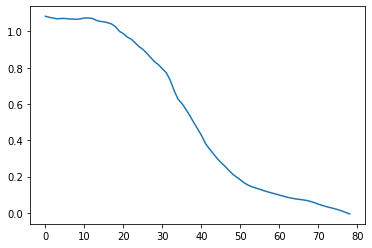

In [6]:
print(lossAll)
print(len(lossAll))
plt.plot(np.array(lossAll))
plt.show()

In [7]:
b = np.full((1, y_test.shape[1]), 0)

print(w, w.shape)
print(b, b.shape)

xTest = preprocessing.maxabs_scale(X_test)
yTest = preprocessing.maxabs_scale(y_test)
print(yTest)

x = np.real(fft.fft2(xTest))
calc = np.dot(w.transpose(), x) + b
yPred = forwardPropagationSigmoid(calc)
y01 = np.where(yPred.reshape(-1) > 0.5, 1, 0)
loss2 = assessment(yTest, y01)
print(y01, y01.dtype, y01.shape)
print('loss after update: ', loss2)
print(confusion_matrix(yTest.reshape(-1), y01))
print(classification_report(yTest.reshape(-1), y01))

[[ 0.00994927]
 [-0.04147712]
 [-0.06721137]
 ...
 [ 0.25769329]
 [ 0.19645498]
 [ 0.15047192]] (31744, 1)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] (1, 72)
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1
 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1] int64 (72,)
loss after update:  0.9371169515394177
[[ 0  0]
 [31 41]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.57      0.73        72

    accuracy                           0.57        72
   macro avg       0.50      0.28      0.36        72
weighted avg       1.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_di